In [2]:
# Import libraries
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate
import matplotlib.pyplot as plt

# Initialize runtime service and backend
service = QiskitRuntimeService()
backend = service.backend(name = "ibm_brisbane")
#backend = service.least_busy(simulator=False, operational=True)

%matplotlib inline

In [3]:
# Function used to show the figure of a circuit, simulate it and display the counts of each state
def circuitResults(title, qc):
    # Show figure of circuit
    fig = qc.draw("mpl")
    fig.suptitle(title)
    plt.show()

    # Simulator
    simulatorUsed = AerSimulator()
    transpiled_circuit = transpile(qc, simulatorUsed)
    result = simulatorUsed.run(transpiled_circuit).result()

    # Get counts of states
    counts = result.get_counts(transpiled_circuit)
    print(counts)

    # Histogram of counts
    plot_histogram(counts)
    plt.show()

In [5]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

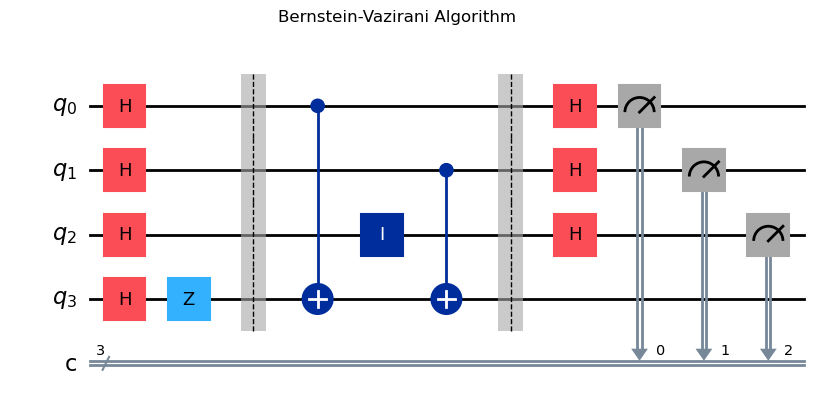

{'011': 1024}


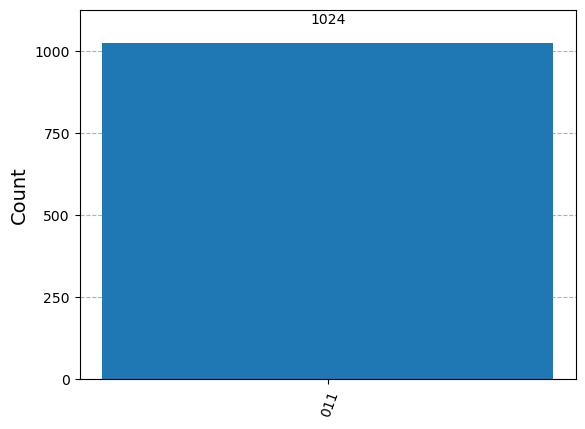

In [8]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

circuitResults("Bernstein-Vazirani Algorithm", bv_circuit)

Job ID is cyrakvzy9d80008d2h00
{'011': 3712, '001': 253, '010': 72, '000': 30, '111': 24, '101': 3, '110': 2}


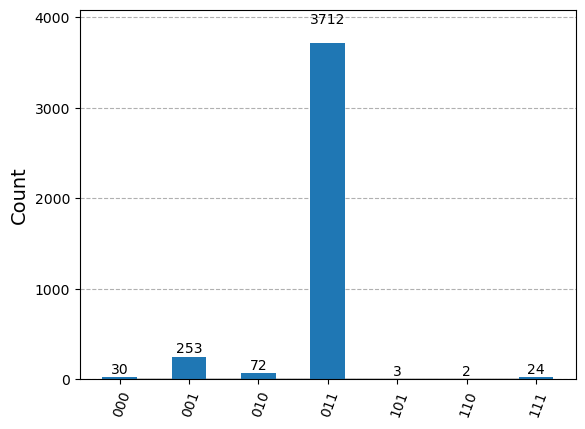

In [10]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.id(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(bv_circuit)
# Step 5: Wait for the job to complete and retrieve the results
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
print(f"Job ID is {job.job_id()}")
# Wait for the job to complete and get the result
job_result = job.result()
pub_result = job_result[0]
# Get the counts from the result
counts = pub_result.data.c.get_counts()
print(f"{counts}")
# Visualize the result
plot_histogram(counts)
plt.hist(counts, bins=30, color='skyblue', edgecolor='black')
plt.show()

In [ ]:

# Import libaries
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qiskit.qpy as qpy

In [ ]:
# Contructs and runs BV circuit using provided oracle circuit and returns "secret number"
def bv_decode(oracle_circ: QuantumCircuit) -> int:
    
    # Convert the loaded oracle circuit to an instruction.
    oracle_inst = oracle_circ.to_instruction()
    
    # The oracle was built with (n+1) qubits (n input qubits, plus one ancilla).
    total_qubits = oracle_inst.num_qubits  # n + 1
    n = total_qubits - 1  # number of input qubits

    # Build the Bernstein-Vazirani circuit.
    circuit = QuantumCircuit(n + 1, n)

    # 1. Apply Hadamard gates to all input (query) qubits.
    for i in range(n):
        circuit.h(i)
    
    # 2. Prepare the ancilla in the |-> state.
    circuit.x(n)
    circuit.h(n)
    circuit.barrier()
    
    # 3. Append the oracle.
    circuit.append(oracle_inst, list(range(total_qubits)), list(range(n)))
    circuit.barrier()
    
    # 4. Apply Hadamard gates again to all input qubits.
    for i in range(n):
        circuit.h(i)
    circuit.barrier()
    
    # 5. Measure all input qubits.
    for i in range(n):
        circuit.measure(i, i)

    # Use QiskitRuntimeService to run the circuit on a real IBM Quantum backend.
    service = QiskitRuntimeService()
    # Choose a backend (for example, the least busy non-simulator device).
    backend = service.least_busy(operational=True, simulator=False)
    print("Using backend:", backend.name)
    
    # Optimize the circuit using a preset pass manager.
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    optimized_circuit = pm.run(circuit)
    

    sampler = Sampler(backend)
    job = sampler.run([optimized_circuit])
    
    job_result = job.result()
    pub_result = job_result[0]

    print("Job ID:", job.job_id())
    result = job.result()
    
    # Extract the measurement results.
    counts = pub_result.data.c.get_counts()

    secret_bitstring = max(counts, key=counts.get)
    recovered_secret = int(secret_bitstring, 2)
    return recovered_secret

In [ ]:
# 
def main():
    # Load the oracle circuit from the QPY file.
    qpy_filename = "oracle.qpy"
    with open(qpy_filename, "rb") as f:
        loaded_oracles = qpy.load(f)
    # qpy.load returns a list; take the first (and only) element.
    oracle_circ = loaded_oracles[0]
    
    # Run the BV algorithm to decode the secret using the loaded oracle.
    recovered_secret = bv_decode(oracle_circ)
    print(f"Recovered secret: {recovered_secret}")

if __name__ == "__main__":
    main()
